In [413]:
# Initialize Otter
import otter
grader = otter.Notebook("HW_3_robot_arm.ipynb")

# Robot arm

Week 1: Building the robot arm and forward kinematics

Part 2: Optimization

Slides: https://docs.google.com/presentation/d/17aiTBmPZidR6op7TvqYRzYatuc_NETYA1BhgpSHQ-FM/edit?usp=sharing

In [414]:
# The usual imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin

In [415]:
# TODO If you wrote your ArmComponent class in the Lab JN then copy the class back to arm_component.py at this point. 
#  Otherwise, nothing will work.

In [416]:
# matrix_rouintes.py functions
import matrix_routines as mt

# This is the class you wrote/are writing in the lab
from arm_component import ArmComponent

In [417]:
# These commands will force JN to actually re-load the external file when you re-execute the import command
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Week 1: Building an arm and doing forward kinematics

Two parts to this problem: The first is creating all of the components and storing them in a data structure (rather than having each one named individually, as was done in the lab). This way, you can have an arbitrary number of links in the arm.

The second part of this assignment is computing the pose matrices for each link, given the angles for each link/finger/gripper.

TODO: Decide how you will store all of the arm components. The simplest approach is to use a list, optionally keeping the gripper components in a list at the end. You can also use a class. 

## Week 1, Part 1: Put all the components together

For this you need to write two things: the first is a function to create all of the components and put them into a data structure (a list, a class, a dictionary - your choice).

The second thing you will need to write is some functions to get the components back out again - that way the autograder can test your results. 

In [418]:

def create_arm_geometry(base_size, link_sizes, palm_width, finger_sizes):
    """ Function to create arm geometry. See next cell for example inputs.
    @param base_size - base width and height as a tuple
    @param link_sizes - link sizes as a list of tuples, one for each link (length, width)
    @param palm_width - single value for palm width
    @param finger_sizes - (length, width) of the finger as a tuple
    @returns Your data structure that has one ArmComponent instance for the base, links, and gripper parts"""

# base
    arm_component_base = ArmComponent(name="Base", color='black', shape_to_use="wedge")
    arm_component_base.matrix_shape_base(base_width=base_size[1], base_height=base_size[0])

# links
    links = []
    for i, link_sizes in enumerate(link_sizes):

        arm_component_link = ArmComponent(name=f'Link_{i}', color='blue', shape_to_use='square')
        arm_component_link.matrix_shape_link(link_sizes[0], link_sizes[1])
        links.append(arm_component_link)

# gripper
    arm_component_palm = ArmComponent(name='Palm', color='tomato', shape_to_use='square')
    arm_component_palm.matrix_shape_palm(palm_width=palm_width)

    arm_component_finger_top = ArmComponent(name='Finger top', color='green', shape_to_use='wedge')
    arm_component_finger_top.matrix_shape_finger(palm_width=palm_width, finger_length=finger_sizes[0], finger_width=finger_sizes[1], b_is_top=True)

    arm_component_finger_bot = ArmComponent(name='Finger bot', color='green', shape_to_use='wedge')
    arm_component_finger_bot.matrix_shape_finger(palm_width=palm_width, finger_length=finger_sizes[0], finger_width=finger_sizes[1], b_is_top=False)
    
# dictionary geometry
    geometry = {'base':arm_component_base,
                'link':links,
                'gripper':(arm_component_palm, arm_component_finger_top, arm_component_finger_bot)}

    return geometry              

    

In [419]:
def get_n_links(arm_geometry):
    """ Return the number of links
    @param arm_geometry - the entire arm
    @return the number of arm links (excluding the base and the gripper)"""

    n_links = len(arm_geometry['link'])

    return n_links

In [420]:
def get_base(arm_geometry):
    """ Return the base component
    @param arm_geometry - the entire arm
    @return the base component)"""
    
    base = arm_geometry['base']

    return base

In [421]:
def get_link(arm_geometry, which_link):
    """ Return the link component
    @param arm_geometry - the entire arm
    @param which_link - which link
    @return the ArmComponent for the link"""
    
    link = arm_geometry['link'][which_link]

    return link

In [422]:
def get_gripper(arm_geometry):
    """ Return the palm and two fingers
    @param arm_geometry - the entire arm
    @return a triplet (palm, top finger, bottom finger)"""

    get_gripper = arm_geometry['gripper']

    return get_gripper

In [423]:
# These are the inputs to your create function. 
base_size_param = (0.5, 1.0)
link_sizes_param = [(0.5, 0.25), (0.3, 0.1), (0.2, 0.05)]
palm_width_param = 0.1
finger_size_param = (0.075, 0.025)

# This function should make an instance of ArmComponent (and call the correct matrix_shape_X function) for
#   the base, one component for each of the links, and another three for the gripper (palm and fingers)
arm_geometry_fk = create_arm_geometry(base_size_param, link_sizes_param, palm_width_param, finger_size_param)

In [424]:
# Correct shape matrices
mat_base_check = np.array([[0.5, 0.0, 0], [0.0, 0.25, 0.25], [0.0, 0.0, 1.0]])
mat_link1_check = np.array([[0.25, 0.0, 0.25], [0.0, 0.125, 0.0], [0.0, 0.0, 1.0]])
mat_link2_check = np.array([[0.15, 0.0, 0.15], [0.0, 0.05, 0.0], [0.0, 0.0, 1.0]])
mat_link3_check = np.array([[0.1, 0.0, 0.1], [0.0, 0.025, 0.0], [0.0, 0.0, 1.0]])
mat_palm_check = np.array([[0.005, 0.0, 0.0], [0.0, 0.05, 0.0], [0.0, 0.0, 1.0]])
mat_finger_top_check = np.array([[0.0, 0.0375, 0.0375], [-0.0125, 0.0, 0.05], [0.0, 0.0, 1.0]])
mat_finger_bot_check = np.array([[0.0, 0.0375, 0.0375], [-0.0125, 0.0, -0.05], [0.0, 0.0, 1.0]])

In [425]:
# This checks the base shape matrix. Notice:
#   Using get_base to get the instance of the base matrix
#   Calling get_shape_matrix() on that instance to get the shape matrix
#   Doing the comparison using np.all(np.isclose())
assert np.all(np.isclose(get_base(arm_geometry_fk).get_shape_matrix(), mat_base_check))

# TODO: Use the get methods and the correct shape matrices above to check the rest of your matrices and
#   your get functions

assert np.all(np.isclose(get_link(arm_geometry_fk, 0).get_shape_matrix(), mat_link1_check))
assert np.all(np.isclose(get_link(arm_geometry_fk, 1).get_shape_matrix(), mat_link2_check))
assert np.all(np.isclose(get_link(arm_geometry_fk, 2).get_shape_matrix(), mat_link3_check))

assert np.all(np.isclose(get_gripper(arm_geometry_fk)[0].get_shape_matrix(), mat_palm_check))
assert np.all(np.isclose(get_gripper(arm_geometry_fk)[1].get_shape_matrix(), mat_finger_top_check))
assert np.all(np.isclose(get_gripper(arm_geometry_fk)[2].get_shape_matrix(), mat_finger_bot_check))

In [426]:
grader.check("build_arm")

build_arm results: All test cases passed!

### Week 1, part 2: Forward kinematics

Although only one function is supplied here (**set_matrices_all_components**) you'll probably want to make some additional ones.

(See homework slides) Each component has a "chain" of matrices that takes the link to the right location. This chain consists of alternating rotation and translation matrices. Each chain consists of all of the translations and rotations for the previous links plus a translation and rotation matrix for the current link. The gripper has the longest chain - it consists of all of the rotations and translation for every link. The fingers have one more (optional).

One confusing thing is that the *last* matrix to be applied is the first one in the chain, reading from left to right in the code (see slides for why). 

There is one "special" matrix - this is the one that takes the first link to the top of the base, pointed up. This is the *last* matrix in the chain. 

Building the chain is the same for all of the links, so you can do this in a **for** loop. This loop is a bit tricky because you don't *quite* take the matrix from the previous link and just add the next rotation/translation pair in the chain. So your code will look like:

**matrix_chain =** special base matrix

-Set the matrix pose for the current link using the matrix_chain and the link's rotation
-Add the right rotation/translation pair to the chain in **matrix_chain**

The palm and fingers can be treated as just another link. If you're doing the optional finger rotation you'll just want to rotate the fingers by the right amount and then add that matrix to the end of the matrix you used for the palm (as done in the lab).

If the **for** loop is challenging, just set each matrix in turn and then look for the pattern.

For full credit this has to work no matter what the link lengths are and how many links there are (hence the **for** loop)

Reminder that you should be using the **set_pose_matrix** method to set the matrices for the components (so it plots properly).

Angle rotated by 1.5707963267948966


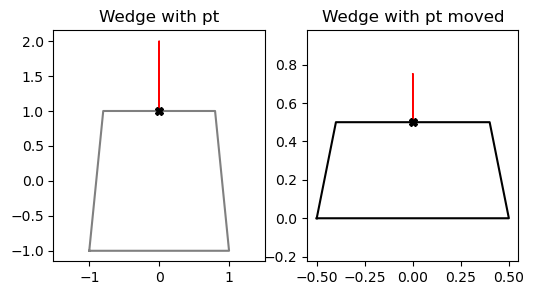

In [427]:
# EXAMPLE CODE
# Getting out where the base of the matrix is and what rotation to use.

# This is the matrix that transforms the base
#  The first item in the arm geometry list is the base
arm_component_base = get_base(arm_geometry_fk)
arm_component_no_transform = ArmComponent(name="Base No transform", color="grey", shape_to_use="wedge")

# Draw the wedge in it's original location, with the point we're interested in (and direction)
pt_on_top = np.array([0, 1, 1]).transpose()
vec_on_top = np.array([0, 1, 0]).transpose()

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].set_title("Wedge with pt")
arm_component_no_transform.plot(axs[0], b_do_pose_matrix=False)
axs[0].plot(pt_on_top[0], pt_on_top[1], 'Xk')
axs[0].arrow(x=pt_on_top[0], y=pt_on_top[1], dx=vec_on_top[0], dy=vec_on_top[1], color="red")

# Multiply the point and the vector by the matrix base's matrix
pt_on_top_moved = arm_component_base.get_shape_matrix() @ pt_on_top
vec_on_top_moved = arm_component_base.get_shape_matrix() @ vec_on_top
axs[1].set_title("Wedge with pt moved")
arm_component_base.plot(axs[1], b_do_pose_matrix=False)
axs[1].plot(pt_on_top_moved[0], pt_on_top_moved[1], 'Xk')
axs[1].arrow(x=pt_on_top_moved[0], y=pt_on_top_moved[1], dx=vec_on_top_moved[0], dy=vec_on_top_moved[1], color="red")

# arctan2 gets the arc tangent of the y, x, and correctly handles the quadrants
angle_of_rotation = np.arctan2(vec_on_top_moved[1], vec_on_top_moved[0])

print(f"Angle rotated by {angle_of_rotation}")

In [428]:
# Add one cell for each additional function you add
def base_link(base_matrix):
    base_top = base_matrix @ np.transpose(np.array([0.0, 1.0, 1.0]))
    return mt.make_translation_matrix(base_top[0], base_top[1]) @ mt.make_rotation_matrix(np.pi/2.0)

In [429]:

def set_matrices_all_components(arm_geometry, angles_list):
    """ For each component, set the matrix that takes the link to its final location.
    In other words, call set_pose_matrix() for each component with the appropriate matrix
    
    The base matrix should be the identity
    @param arm_geometry - the arm geometry data structure you created
    @param angles_list - a list of angles, one for each link, one for the palm, and one for the fingers
    """

    # TODO: Set the pose matrix for each arm component

    # The base link - it doesn't move, so this is the identity matrix. Setting here just to show the syntax of it
    get_base(arm_geometry).set_pose_matrix(np.identity(3))


    # TODO:
    #  The first link matrix needs to rotate the link, then translate it to the top of the base, pointing up
    #  Build the latter part of that matrix by figuring out where (0.0, 1.0) on the base wedge went in the world coordinate. (see Example code in JN)
    #    Remember that the shape matrix can be gotten by get_shape_matrix
    #  Step 1: Get the matrix from the base link
    #  Step 2: Find the point in the world coordinate, which is (0.0,1.0) in the base wedge coordinate.
    #          (point_in_world = matrix @ point_in_local, Remember that the matrix is 3x3.)
    #  Step 3: Rotate first to point up, then translate (Point in step 2)
    base_matrix = base_link(get_base(arm_geometry).get_shape_matrix())

    # Double checking that the geometry has the same number of links as the angles
    assert get_n_links(arm_geometry) == len(angles_list) - 1
    
    for ilink, ang in enumerate(angles_list[0:-1]):
        # TODO 
        # Keep a matrix that does all of the transforms up to that point (getting the link
        #  to the end of the last link and then rotating by that link) then append the rotation matrix class Armfor the link
        # See Homework slides
        # This is the current link
        link_to_edit = get_link(arm_geometry, ilink)
        link_to_edit.set_pose_matrix(base_matrix @ mt.make_rotation_matrix(ang))
        T = mt.make_translation_matrix(link_to_edit.link_length)
        R = mt.make_rotation_matrix(ang)

        link_to_edit.angle = ang

        base_matrix = base_matrix @ R @ T
        


    # Now do the gripper (palm) - the fingers are optional
    # If you don't do the fingers, just use the same matrix for the palm AND the fingers
    palm_obj, top_finger_obj, bot_finger_obj = get_gripper(arm_geometry)
    palm_angle = angles_list[-1][0]
    finger_angle = angles_list[-1][1]

    # TODO Set the matrix pose for the palm. This is exactly the same as setting the link pose
    palm_obj.angle = palm_angle
    palm_obj.set_pose_matrix(base_matrix @ mt.make_rotation_matrix(palm_angle))

    top_finger_obj.angle = finger_angle
    top_finger_obj.set_pose_matrix(base_matrix @ mt.make_rotation_matrix(finger_angle))

    bot_finger_obj.angle = finger_angle
    bot_finger_obj.set_pose_matrix(base_matrix @ mt.make_rotation_matrix(finger_angle))

    # TODO (optional):
    #   Translate the base of the finger back to the origin, rotate it, then translate it back out
    #   Reminder: The middle of the finger can be found using mt.get_dx_dy_from_matrix
    #    Note: You want to move the base of the finger, NOT the middle, to the origin before you do the rotate
    

In [430]:
## Check the combined link/gripper/finger rotations
# Several different angles to check your routines with 
# Pass the one you want to check into set_matrices_all_components in the cell below
#  Feel free to change these
angles_none = [0.0, 0.0, 0.0, [0.0, 0.0]]
angles_check_link_0 = [np.pi/4, 0.0, 0.0, [0.0, 0.0]]
angles_check_link_0_1 = [np.pi/4, -np.pi/4, 0.0, [0.0, 0.0]]
angles_check_wrist = [np.pi/2, -np.pi/4, -3.0 * np.pi/4, [np.pi/3.0, 0.0]]
angles_check_fingers = [np.pi/2, -np.pi/4, -3.0 * np.pi/4, [0.0, np.pi/4.0]]

# Don't change this one
angles_check = [np.pi/2, -np.pi/4, -3.0 * np.pi/4, [np.pi/3.0, np.pi/4.0]]


In [431]:
# Plotting function - this just uses the get_xx functions and the plot function on each component
def plot_complete_arm(axs, arm_geometry):
    """ Plot all arm components in the same window
    @param axs are the axes of the plot window
    @param arm is your data structure"""

    # Put the box around the figure
    box_pts = mt.make_scale_matrix(0.75, 0.75) @ ArmComponent.points_in_a_square()
    axs.plot(box_pts[0, :], box_pts[1, :], color="lightgrey", linestyle='solid')

    # The base and links
    get_base(arm_geometry).plot(axs, b_do_pose_matrix=True)
    for ilink in range(0, get_n_links(arm_geometry)):
        get_link(arm_geometry, ilink).plot(axs, b_do_pose_matrix=True)

    # The gripper
    for component in get_gripper(arm_geometry):
        component.plot(axs, b_do_pose_matrix=True)

    axs.set_title("Arm")
    axs.axis("equal")
    axs.legend(loc="lower left")


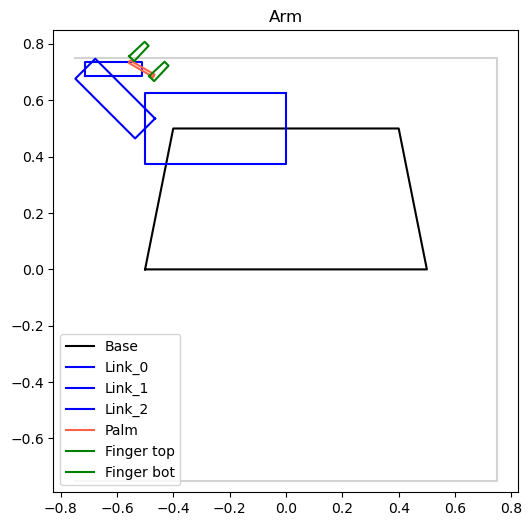

In [432]:
# Use this cell to visually check the results
# With angles_none it should point straight up
# TODO: Change angles_check to be the angles above to check various pieces
set_matrices_all_components(arm_geometry_fk, angles_check)

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plot_complete_arm(axs, arm_geometry_fk)

In [433]:
# Don't change this one - the cells below assume these are the angles
angles_check = [np.pi/2, -np.pi/4, -3.0 * np.pi/4, [np.pi/3.0, np.pi/4.0]]
set_matrices_all_components(arm_geometry_fk, angles_check)


In [434]:
# Check the returned values
np.set_printoptions(precision=4, floatmode='fixed')  # Print out with 4 digits of precision

mat_check_base = np.identity(3)
assert np.all(np.isclose(get_base(arm_geometry_fk).get_pose_matrix(), mat_check_base, atol=0.01))

In [435]:
mat_check_link_1 = np.array([[ -1.0,  0.0,  0.0], \
                             [  0.0, -1.0,  0.5], \
                             [  0.0,  0.0,  1.0]])
                             
mat_check_link_2 = np.array([[ -0.7071, -0.7071, -0.5], \
                             [  0.7071, -0.7071,  0.5], \
                             [  0.0,     0.0,  1.0]])

mat_check_link_3 = np.array([[ 1.0, 0.0, -0.71213], \
                             [ 0.0, 1.0,  0.71213], \
                             [ 0.0, 0.0,  1.0]])

for ilink, m in enumerate((mat_check_link_1, mat_check_link_2, mat_check_link_3)):
    assert(np.all(np.isclose(get_link(arm_geometry_fk, ilink).get_pose_matrix(), m, atol=0.01)))

In [436]:
mat_check_wrist = np.array([[ 0.5, -0.8660,  -0.5121], \
                            [ 0.8660,  0.5,   0.7121], \
                            [ 0.0,  0.0,  1.0]])
assert np.all(np.isclose(get_gripper(arm_geometry_fk)[0].get_pose_matrix(), mat_check_wrist, atol=0.01))

In [437]:
grader.check("forward_ik")

forward_ik results: All test cases passed!

# Week 2: Gripper location

TODO: edit **get_gripper_location** to return the x,y location of the gripper.

A reminder that the grasp location is offset from the palm by a bit

In [438]:
def get_gripper_location(arm_geometry, perc_along_fingers):
    """ Get the gripper grasp location (between the fingers) given the arm
    Assumes the matrices for each component have been set already
    Assumes the distance off the palm has been already been stored
    @param arm_geometry
    @param perc_along_fingers - percentage along the length of the fingers to use as the grasp location
    @return x,y as a tuple - the location of the "grasp" point in the gripper
    """

    # TODO:
    # Step 1: Calculate the grasp distance off of the palm using the length of the fingers
    # Step 1: Get the pose matrix for the palm
    # Step 2: Multiply the palm matrix by [grasp_dist, 0] to get the location of the grasp
    finger_length = get_gripper(arm_geometry)[2].link_length
    grasp_distance = perc_along_fingers*finger_length

    palm_matrix = get_gripper(arm_geometry)[0].get_pose_matrix()
    grasp_location_vector = [grasp_distance, 0, 1]
    grasp_location = palm_matrix @ grasp_location_vector

    # Format for returning a tuple
    return (grasp_location[0], grasp_location[1])


In [439]:
# Check the gripper location function
# As in the previous problem, you can use the "simpler" angles to check your function
angles_check_gripper = [np.pi/3, -np.pi/6, 3.0 * np.pi/6, [-np.pi/4, np.pi/4.0]]

# Making another copy of the arm geometry to use in these problems
arm_geometry_gripper_check = create_arm_geometry(base_size_param, link_sizes_param, palm_width_param, finger_size_param)

# Actually set the matrices
set_matrices_all_components(arm_geometry_gripper_check, angles_check_gripper)

# Check the trasp location is correct (there is plotting code in the next cell)
grasp_loc = get_gripper_location(arm_geometry_gripper_check, 0.75)
assert(np.isclose(grasp_loc[0], -0.8106, atol=0.01) and np.isclose(grasp_loc[1], 0.92437, atol=0.01))


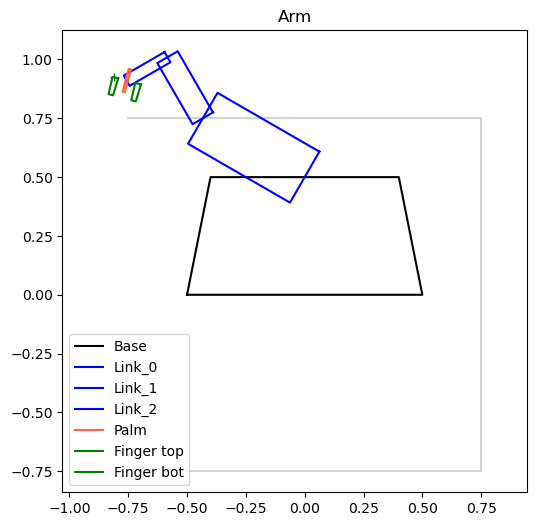

In [440]:

# Now actually plot - the grasp grip location should show up as a green cross
fig2, axs2 = plt.subplots(1, 1, figsize=(6, 6))
plot_complete_arm(axs2, arm_geometry_gripper_check)

axs2.plot(grasp_loc[0], grasp_loc[1], '+g', label="Grasp location")


In [441]:
# Do NOT change these or the autograder tests won't work
angles_check_gripper = [np.pi/3, -np.pi/6, 3.0 * np.pi/6, [-np.pi/4, np.pi/4.0]]

# Actually set the matrices
set_matrices_all_components(arm_geometry_gripper_check, angles_check_gripper)

grasp_loc_check = get_gripper_location(arm_geometry_gripper_check, 0.75)

In [442]:
grader.check("gripper_loc")

gripper_loc results: All test cases passed!

## Generalization check

If nothing has been "hardwired" in, this should just work - changing the geometry, the starting angles, the target point. However, if you've hardwired something in, it probably won't...

In [443]:
# Create another arm geometry
base_size_longer_param = (0.5, 0.25) # squished
link_sizes_longer_param = [(0.3, 0.15), (0.2, 0.09), (0.1, 0.05), (0.075, 0.03)]
palm_width_longer_param = 0.15
finger_size_longer_param = (0.085, 0.015)


# This function calls each of the set_transform_xxx functions, and puts the results
# in a list (the gripper - the last element - is a list)
arm_longer = create_arm_geometry(base_size_longer_param, link_sizes_longer_param, palm_width_longer_param, finger_size_longer_param)

# Set the angles of the arm
angles_start_longer = [-np.pi/4.0, -np.pi/4, 1.2 * np.pi/4, -1 * np.pi/8, [-np.pi/3.0, np.pi/6.0]]
set_matrices_all_components(arm_longer, angles_start_longer)

grasp_loc_longer_check = get_gripper_location(arm_longer, 0.5)


assert np.all(np.isclose(grasp_loc_longer_check, (0.57220, 0.811941), atol=0.01))

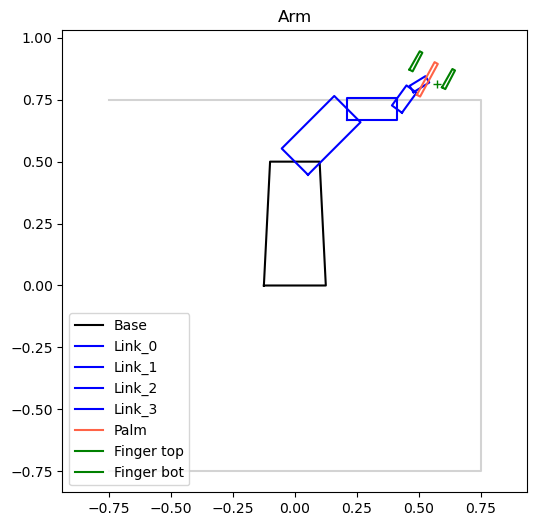

In [444]:
# Now actually plot - the grasp grip location should show up as a green cross
fig3, axs3 = plt.subplots(1, 1, figsize=(6, 6))
plot_complete_arm(axs3, arm_longer)

axs3.plot(grasp_loc_longer_check[0], grasp_loc_longer_check[1], '+g', label="Grasp location")


In [445]:
grader.check("generalization_check")

generalization_check results: All test cases passed!

# FMin optimization

In this problem you're going to write a function **distance_from_angles_for_fmin** that you will pass to fmin in order to have **fmin** find the angles that bring the gripper location to the target points

TODO: Edit **do_fmin** to call **func_for_fmin** with the appropriate angles, etc


In [446]:
def distance_from_angles_for_fmin(angles, arm_geometry, perc_along_fingers, target):
    """ Compute the distance from the grasp point to the target
    @param angles as a numpy array, one angle for each joint
    @param arm_geometry - your data structure that stores the arm
    @param perc_along_fingers - the distance from the palm that is the grasp (as a percentage of finger length)
    @param target - a tuple with the desired x,y location
    @return The distance between the target and the gripper grasp point"""

    # TODO: step 1, convert the numpy array into the format we've been using for the angles
    #  [a1, a2, a3, ... [ap, af]]
    #  Set the angles of the fingers (af) to be zero
    #  If there are 3 links, then angles will have four values (the last angle is the wrist/palm angle, ap)

    angles_as_list = angles.tolist()[:-1]
    angles_as_list.append([angles[-1], 0])

    # TODO: Call set_matrices_all_components with the arm_geometry and the angles you just created
    #    This sets the Matrix_pose's to the correct values for these angles
    set_matrices_all_components(arm_geometry, angles_as_list)

    # TODO - call get_gripper_location to get gx, gy (the gripper location with these angles)
    gx, gy = get_gripper_location(arm_geometry, perc_along_fingers)

    # TODO - return any one of the above distance values. This should be a single number
    return abs(gx - target[0]) + abs(gy - target[1])

In [447]:
# Make a new copy of the arm
arm_geometry_reach = create_arm_geometry(base_size_param, link_sizes_param, palm_width_param, finger_size_param)
perc_along_fingers_reach = 0.75

# Set the starting angles of the arm
angles_start = [np.pi/6.0, -np.pi/4, 1.5 * np.pi/4, [np.pi/3.0, -np.pi/8.0]]
set_matrices_all_components(arm_geometry_reach, angles_start)

# Get the gripper location
gx, gy = get_gripper_location(arm_geometry_reach, perc_along_fingers_reach)

# Check that your function returns zero
#   This converts the start angles to a numpy array
angles_start_flat_list = [a for a in angles_start[0:-1]]
angles_start_flat_list.append(angles_start[-1][0])                          
angles_start_as_np_array = np.array(angles_start_flat_list)
dist = distance_from_angles_for_fmin(angles=angles_start_as_np_array, 
                                     arm_geometry=arm_geometry_reach, 
                                     perc_along_fingers=perc_along_fingers_reach, 
                                     target=(gx, gy))

assert(np.isclose(dist, 0.0))

# Try some angles that should be further away
angles_not_start_as_np_array = angles_start_as_np_array * 0.5
dist_far_away = distance_from_angles_for_fmin(angles=angles_not_start_as_np_array, 
                                              arm_geometry=arm_geometry_reach, 
                                              perc_along_fingers=perc_along_fingers_reach, 
                                              target=(gx, gy))

assert(dist_far_away > 0.0)

In [448]:
grader.check("optimization_dist_func")

optimization_dist_func results: All test cases passed!

## Do the fmin call

Here you're going to set up the **fmin** call. As always, you can write this outside of the function call then put it in the function after it's working

- First, convert the starting angles to a numpy array (see previous question)
- Next, call fmin with the function distance_from_angles_for_fmin and a tuple that has the arm_geometry and the target in it


In [449]:
def do_fmin(angles_start, arm_geometry, perc_along_fingers, target):
    """ Set the angles/matrices of arm_geometry so they reach the target point
    @param - angles to start with
    @param - your arm geometry
    @param - perc_along_fingers distance of the grasp point from palm
    @param - the target as a tuple (x,y)
    @return the arm geometry with the angles set to the result of calling fmin
    """
    # TODO - convert the list of angles to a numpy array (see above)
    angles_as_nparray = np.array([0, 0])
    angles_flat = [a for a in angles_start[:-1]]
    angles_flat.append(angles_start[-1][0])
    angles_as_nparray = np.array(angles_flat)
    

    # TODO - now call fmin with your function, the starting angles, and the remaining paramters in args
    fmin_angles = fmin(distance_from_angles_for_fmin, angles_as_nparray, args=(arm_geometry, perc_along_fingers, target))
    # TODO - set arm_geometry's Matrix_pose to have the ones for these joint angles
    #   You can either convert the angles back to a list or just call distance_from_angles_for_fmin
    fmin_angles_list = fmin_angles.tolist()[:-1]
    fmin_angles_list.append([fmin_angles[-1], 0])


    set_matrices_all_components(arm_geometry, fmin_angles_list)
    return arm_geometry

In [450]:
# You must start with these angles
angles_start = [np.pi/6.0, -np.pi/4, 1.5 * np.pi/4, [np.pi/3.0, -np.pi/8.0]]
# The target
target = np.array([0.55, 1.15])

arm_geometry_optimized = do_fmin(angles_start, arm_geometry_reach, perc_along_fingers_reach, target)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 148
         Function evaluations: 263


In [451]:
assert(np.isclose(get_gripper_location(arm_geometry_optimized, perc_along_fingers_reach)[0], target[0], atol=0.01))
assert(np.isclose(get_gripper_location(arm_geometry_optimized, perc_along_fingers_reach)[1], target[1], atol=0.01))

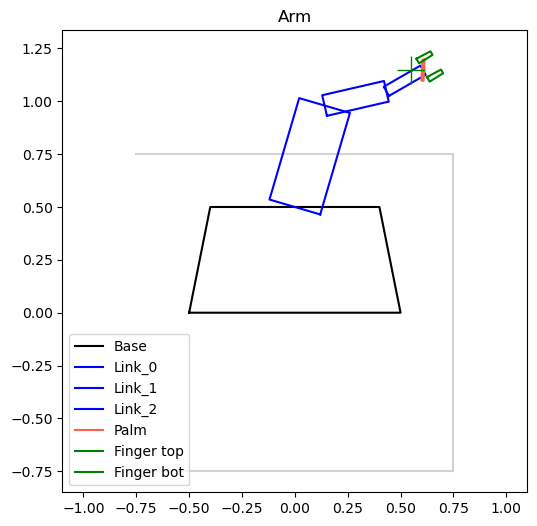

In [452]:
# Plot arm with target
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plot_complete_arm(axs, arm_geometry_optimized)
axs.plot(target[0], target[1], '+g', markersize=20)

In [453]:
grader.check("do_fmin")

do_fmin results: All test cases passed!

# Generalization

If nothing has been "hardwired" in, this should just work - changing the geometry, the starting angles, the target point. However, if you've hardwired something in, it probably won't...

In [454]:
# Create the arm geometry
base_size_param = (0.5, 0.25) # squished
link_sizes_param = [(0.3, 0.15), (0.2, 0.09), (0.1, 0.05), (0.075, 0.03)]
palm_width_param = 0.15
finger_size_param = (0.085, 0.015)
longer_finger_grasp_perc = 0.75


# This function calls each of the set_transform_xxx functions, and puts the results
# in a list (the gripper - the last element - is a list)
arm_longer = create_arm_geometry(base_size_param, link_sizes_param, palm_width_param, finger_size_param)

# Set the angles of the arm
angles_start_longer = [-np.pi/4.0, -np.pi/4, 1.2 * np.pi/4, -1 * np.pi/8, [-np.pi/3.0, np.pi/6.0, -np.pi/6.0]]
set_matrices_all_components(arm_longer, angles_start_longer)

target_longer = np.array([0.3, -0.15])

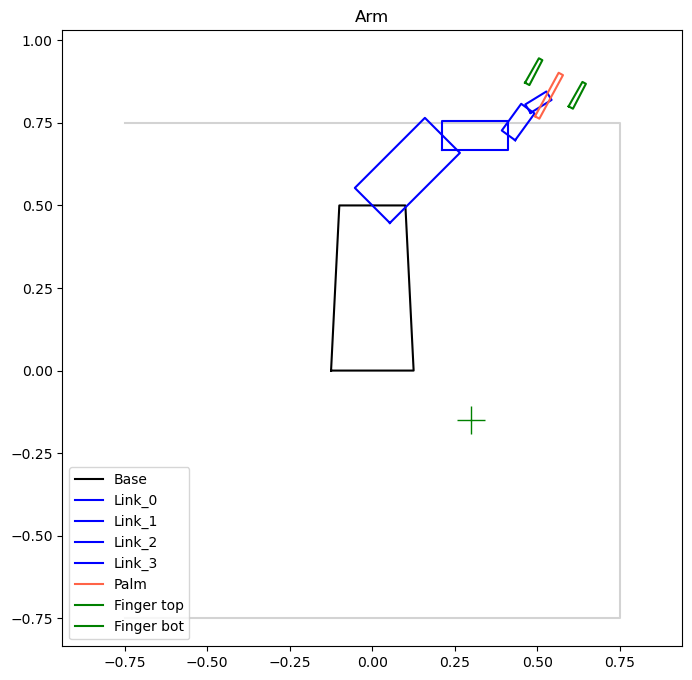

In [455]:
# Plot arm with target
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_complete_arm(axs, arm_longer)
axs.plot(target_longer[0], target_longer[1], '+g', markersize=20)

In [456]:
# Do the optimization
arm_longer_optimized = do_fmin(angles_start_longer, arm_longer, longer_finger_grasp_perc, target_longer)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 545
         Function evaluations: 910


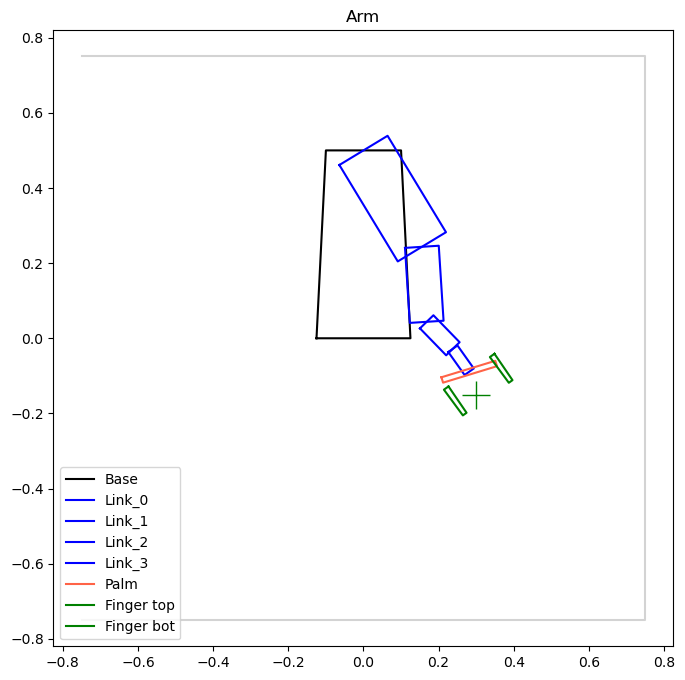

In [457]:
# Plot arm with target
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_complete_arm(axs, arm_longer_optimized)
axs.plot(target_longer[0], target_longer[1], '+g', markersize=20)

In [458]:
assert(np.isclose(get_gripper_location(arm_longer_optimized, longer_finger_grasp_perc)[0], target_longer[0], atol=0.01))
assert(np.isclose(get_gripper_location(arm_longer_optimized, longer_finger_grasp_perc)[1], target_longer[1], atol=0.01))

In [459]:
grader.check("generalization")

generalization results: All test cases passed!

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [460]:

# List of names (creates a set)
worked_with_names = {"Zander Ray, Luc Dale"}
# List of URLS TAF4 (creates a set)
websites = {"https://numpy.org/"}
# Approximate number of hours, including lab/in-class time
hours = 12

In [461]:
grader.check("hours_collaborators")

hours_collaborators results: All test cases passed!

### To submit

(Did you read me?)

- Submit this .ipynb file AND arm_component.py. If you don't include arm_component.py Gradescope cannot magically reach out to your computer and find our it.
- We will supply matrix_routines.py for you (it won't break anything if you do include it)

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

Lots of people forget arm_component.py. Please check your autograder score to see if you are one of them.

Make sure you remove all the print statements you put in that print out lots of stuff.